In [1]:
# convenience directory variables
ROOT_DIR = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
TRAIN_DIR = f'{ROOT_DIR}/train_images'
SEG_DIR = f'{ROOT_DIR}/segmentations'

In [2]:
import pandas as pd
import numpy as np
import random
import glob
import os
import time
import PIL
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import matplotlib.patches as patches

In [3]:
#!pip install dicomsdl
import pydicom
#import dicomsdl as dicoml
from tqdm.notebook import tqdm

In [4]:
im_info = pd.read_pickle('/kaggle/input/boxes-info/im_info.pkl')
train_series_meta = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv")
im_info = im_info.merge(train_series_meta, on=['series_id'], how='left') 
im_info.head()

,series_id,images,image_size,liver_frames,spleen_frames,kidney_left_frames,kidney_right_frames,liver_boxes,spleen_boxes,kidney_left_boxes,kidney_right_boxes,liver_abox,spleen_abox,kidney_left_abox,kidney_right_abox,patient_id,aortic_hu,incomplete_organ
0,39222,208,"(512, 512)","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...","[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...","[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6...","[[194, 190, 209, 204], [183, 170, 226, 221], [...","[[357, 286, 371, 296], [337, 279, 379, 306], [...","[[316, 298, 343, 328], [312, 291, 349, 330], [...","[[196, 283, 213, 303], [190, 278, 216, 308], [...","[109, 108, 341, 329]","[306, 228, 420, 353]","[309, 230, 382, 330]","[150, 223, 221, 317]",47065,366.75,0
1,52961,293,"(512, 512)","[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...","[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...","[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9...","[[177, 233, 203, 265], [170, 227, 229, 271], [...","[[342, 330, 362, 336], [335, 326, 368, 338], [...","[[299, 293, 311, 312], [295, 289, 315, 316], [...","[[213, 298, 222, 312], [208, 293, 224, 318], [...","[121, 175, 352, 344]","[319, 295, 405, 343]","[285, 257, 364, 330]","[153, 236, 228, 328]",42008,209.00,0
2,7334,152,"(512, 512)","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[[164, 243, 198, 280], [156, 233, 211, 288], [...","[[344, 325, 387, 345], [338, 324, 398, 354], [...","[[310, 345, 329, 370], [308, 340, 335, 375], [...","[[200, 344, 213, 359], [185, 327, 219, 367], [...","[108, 190, 338, 389]","[330, 282, 431, 392]","[300, 324, 385, 390]","[135, 283, 226, 381]",19410,96.00,0
3,15415,187,"(512, 512)","[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...","[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5...","[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6...","[[145, 228, 160, 241], [132, 215, 172, 256], [...","[[316, 284, 331, 290], [309, 284, 356, 295], [...","[[291, 276, 314, 297], [282, 268, 323, 299], [...","[[201, 281, 212, 294], [195, 274, 217, 301], [...","[78, 118, 298, 331]","[298, 254, 401, 310]","[278, 223, 371, 301]","[156, 219, 229, 314]",57444,322.00,0
4,51141,371,"(512, 512)","[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...","[54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[110, 111, 112, 113, 114, 115, 116, 117, 118, ...","[86, 87, 88, 89, 90, 91, 93, 94, 96, 97, 98, 9...","[[144, 234, 157, 247], [140, 229, 162, 252], [...","[[337, 346, 337, 346], [336, 346, 338, 346], [...","[[301, 318, 310, 325], [297, 312, 320, 329], [...","[[188, 336, 188, 343], [188, 330, 188, 344], [...","[74, 101, 362, 352]","[286, 294, 408, 368]","[286, 255, 370, 340]","[106, 188, 195, 344]",13794,190.00,0


In [5]:
# create dataset directory structure
dataset_name = 'RSNA_box_detection_data'
def create_dir(dataset_name) -> (str, str, str):
    dataset_dirpath = os.path.join(os.getcwd(), dataset_name)
    train_dirpath =  os.path.join(dataset_dirpath, "train")
    val_dirpath =  os.path.join(dataset_dirpath, "val")
    config_path = os.path.join(dataset_dirpath, "dataset.yaml")

    if not os.path.exists(dataset_dirpath):
        os.makedirs(os.path.join(train_dirpath, "images"), exist_ok=True)
        os.makedirs(os.path.join(train_dirpath, "labels"), exist_ok=True)
        os.makedirs(os.path.join(val_dirpath, "images"), exist_ok=True)
        os.makedirs(os.path.join(val_dirpath, "labels"), exist_ok=True)
    else:
        raise RuntimeError()
        
    return train_dirpath, val_dirpath, config_path

In [6]:
#define split ratio
# Set sizes for train and val datasets
def get_splitratio(train_size, length):
    train_size = 0.85
    train_size = round(length * train_size)
    val_size = length - train_size
    assert train_size + val_size == length
    return train_size, val_size

In [7]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
#         pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)

    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2    
    
    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array

In [8]:
## load image with discosdl
def load_image(filepath:str, voi_lut = True):
    dicom_image = pydicom.read_file(filepath)

    img = standardize_pixel_array(dicom_image)
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    if dicom_image.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
        
    return (img * 255).astype(np.uint8)


In [9]:
def check_box_validity(box) -> bool:
    # check if box in pascal_voc format is valid
    if box[0]<box[2] and box[1] < box[3]:
        return True
    else:
        return False

In [10]:
# get list of all images in prepared dataset and their bboxes
image_paths_all = []
bboxes_all = []
labels_all = []
classes_dict = {
            'liver': 0,
            'spleen': 1,
            'kidney_left': 2,
            'kidney_right': 3,
             }

for index, row in im_info.iterrows():  
    bboxes = []
    llabels = []
    folder = f"{TRAIN_DIR}/{row['patient_id']}/{row['series_id']}"
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    #filenames = [[TRAIN_DIR, str(row['patient_id']), str(row['series_id']), str(filename), '.dcm'] for filename in filenames]
    filenames = [[row['patient_id'], row['series_id'], filename] for filename in filenames]
    
    image_paths_all += filenames
    for i in range(len(filenames)):
        boxes = []
        labels = []
        if i in row['liver_frames']: # kidney_left_frames kidney_right_frames]
            box_ind = row['liver_frames'].index(i)
            if check_box_validity(row['liver_boxes'][box_ind]):
                labels.append(classes_dict['liver'])
                boxes.append(row['liver_boxes'][box_ind])
            
        if i in row['spleen_frames']: # spleen_frames kidney_left_frames kidney_right_frames]
            box_ind = row['spleen_frames'].index(i)
            if check_box_validity(row['spleen_boxes'][box_ind]):
                labels.append(classes_dict['spleen'])
                boxes.append(row['spleen_boxes'][box_ind])
            
        if i in row['kidney_left_frames']: # spleen_frames kidney_left_frames kidney_right_frames]
            box_ind = row['kidney_left_frames'].index(i)
            if check_box_validity(row['kidney_left_boxes'][box_ind]):
                labels.append(classes_dict['kidney_left'])
                boxes.append(row['kidney_left_boxes'][box_ind])
            
        if i in row['kidney_right_frames']: # spleen_frames kidney_left_frames kidney_right_frames]
            box_ind = row['kidney_right_frames'].index(i)
            if check_box_validity(row['kidney_right_boxes'][box_ind]):
                labels.append(classes_dict['kidney_right'])
                boxes.append(row['kidney_right_boxes'][box_ind])
        
        assert len(boxes) == len(labels)
        bboxes.append(boxes)
        llabels.append(labels)
        
    assert len(bboxes) == len(filenames)== len(llabels)
    bboxes_all += bboxes
    labels_all += llabels
    
assert len(bboxes_all) == len(labels_all) ==len(image_paths_all) == im_info['images'].sum()

data = []
for im_path, labels, boxes in zip(image_paths_all, labels_all, bboxes_all):
    data.append({"patient_id": im_path[0], "series_id": im_path[1], "image_id": im_path[2], "labels": np.array(labels), "boxes": np.array(boxes)})


In [11]:
data[0]

{'patient_id': 47065,
 'series_id': 39222,
 'image_id': 45,
 'labels': array([], dtype=float64),
 'boxes': array([], dtype=float64)}

In [12]:
a = 0
random.seed(2137)
for i in bboxes_all:
    if not i:
        a+=1
print('Empty images: ', a)
print('Images with boxes: ', len(bboxes_all)-a)
# We have to trim some empty images

data_empty =  [sample for sample in data if sample["boxes"].size == 0]
data_valid = [sample for sample in data if sample["boxes"].size != 0]
assert len(data_empty)+len(data_valid) ==  im_info['images'].sum()

empty_size = 0.1
valid_size = len(data_valid)
#sample right number of images wo boxes to add to dataset (some say that it helps with false positives)
sampled_empty = random.sample(data_empty, int(valid_size*empty_size))

full_data = data_valid + sampled_empty
random.shuffle(full_data)

assert len(full_data) == len(sampled_empty) + len(data_valid)

Empty images:  41361
Images with boxes:  29180


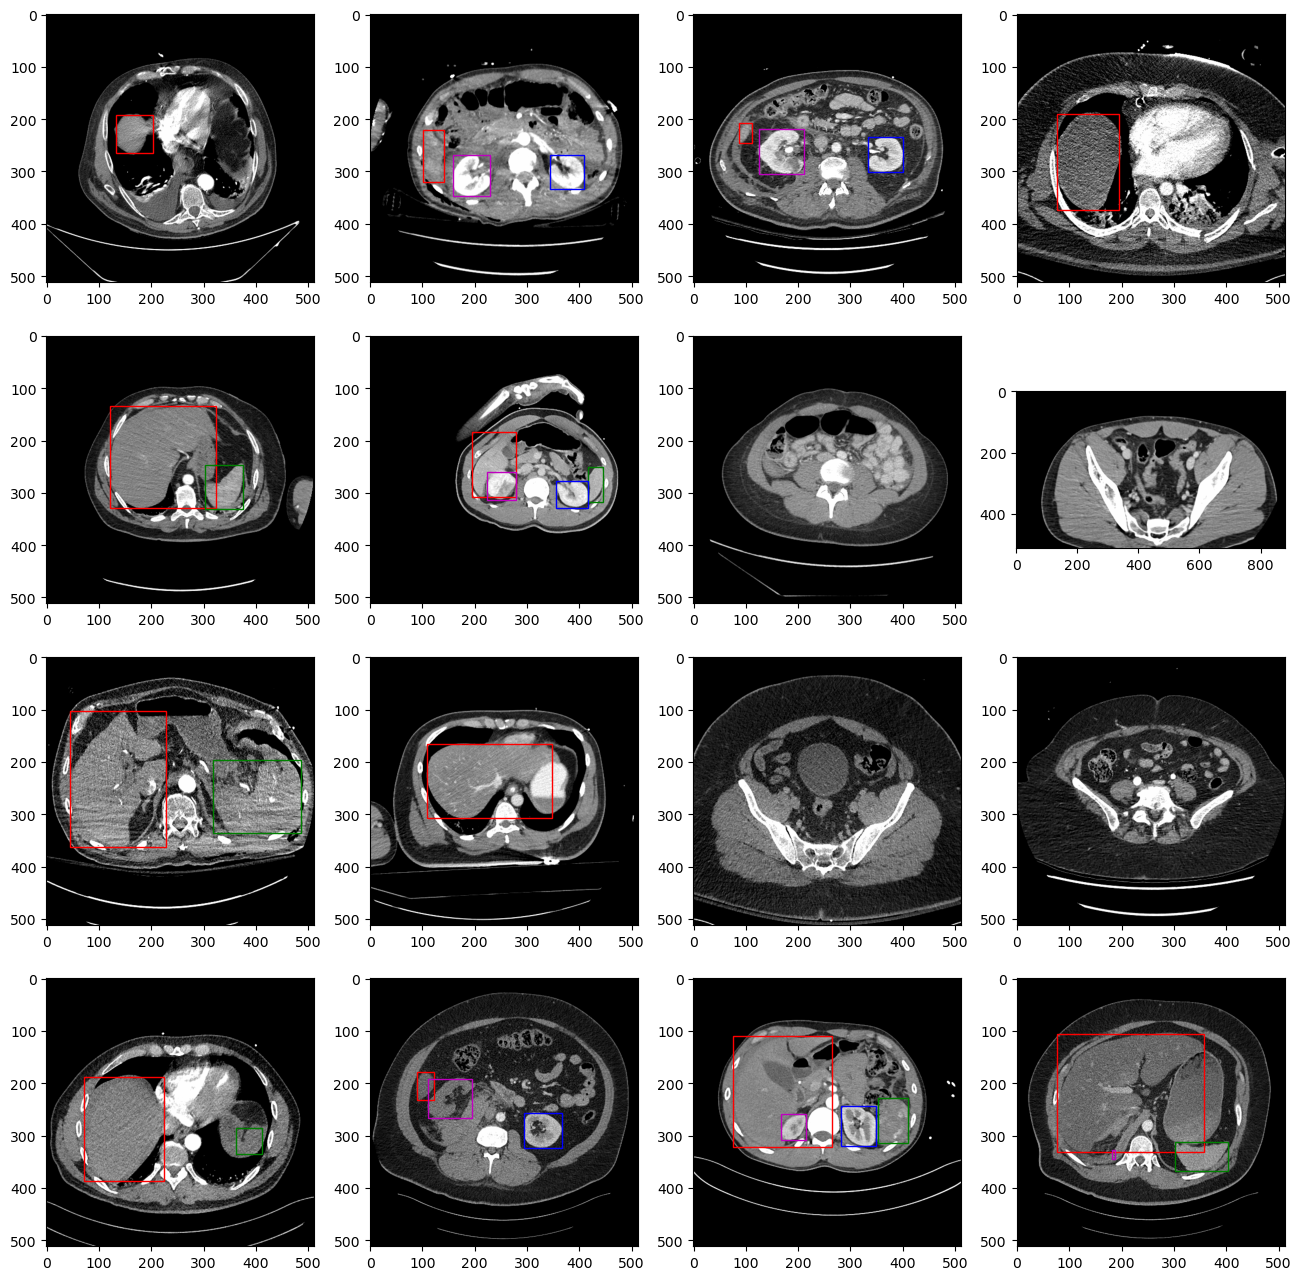

In [13]:
#plot some examples to check if all is ok
fig, axis = plt.subplots(4,4, figsize = (16,16))
ax = axis.ravel()
samples = random.sample(full_data, len(ax))
color_dict = dict([(0,'r'),(1,'g'), (2,'b'), (3,'m')])

for i in range(len(ax)):
    image_path = f"{TRAIN_DIR}/{samples[i]['patient_id']}/{samples[i]['series_id']}/{samples[i]['image_id']}.dcm"
    cor = load_image(image_path, voi_lut = True)
    ax[i].imshow(cor, cmap='gray', vmin=0, vmax = 255)
    boxes = samples[i]['boxes']
    if np.any(boxes):
        for box, label in zip(boxes, samples[i]['labels']):
            color = color_dict[label]
            ax[i].add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=color, facecolor='none', visible=True))

In [14]:
import albumentations as A
import cv2
transform = A.Compose([
    A.augmentations.geometric.resize.Resize(width=256, height=256),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=["category_id"]))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
def pv2yolo(box):
    return np.array([(box[0] + box[2])/2, (box[1] + box[3])/2, box[2]- box[0], box[3] - box[1]])

def pv2coco(box):
    return np.array([box[0], box[1], (box[2]- box[0]), (box[3] - box[1])])

def yolo2coco(box):
    return np.array([box[0] - box[2]/2, box[1] - box[3]/2, box[2], box[3]])

In [16]:
from typing import Literal

def prepare_sample(sample, folder:str, extension = '.png', bbox_type:Literal['pascal_voc', 'coco', 'yolo'] = 'pascal_voc', normalize:bool = True):
    dcm_image_path = f"{TRAIN_DIR}/{sample['patient_id']}/{sample['series_id']}/{sample['image_id']}.dcm"
    identifier = f"{sample['patient_id']}_{sample['series_id']}_{sample['image_id']}"
    final_image_path = folder + '/images/' + identifier + extension
    label_path = folder + '/labels/' + identifier + '.txt'
    
    image = load_image(dcm_image_path, voi_lut = True)
    boxes = sample['boxes']
    labels = sample['labels']
    
    if image.shape != (256,256):
        #resize
        transformed = transform(image=image, bboxes = boxes, category_id=labels)
        image = np.array(transformed['image'])
        boxes = np.array(transformed['bboxes']).round()
        labels = np.array(transformed['category_id'])
            
    #save image
    cv2.imwrite(final_image_path, image)
    #save labels
    if sample["boxes"].size != 0:
        with open(label_path , "w") as file:
            for label, box in zip(labels, boxes):
                if bbox_type == 'yolo':
                    box = pv2yolo(box)
                elif bbox_type == 'coco':
                    box = pv2coco(box)
                if normalize:
                    box = box/256.0
                    
                box = " ".join(map(str, box))
                file.write(f"{label} {box}\n")

In [17]:
#import shutil
#shutil.rmtree("/kaggle/working/RSNA_data")

In [18]:
# create dataset directory structure
dataset_name = 'RSNA_data'
train_dirpath, test_dirpath, config_path = create_dir(dataset_name)

# train test split
train_size = 0.85
all_samples = len(full_data)
split_ind = int(train_size*all_samples)
# have in mind that the full data list was previously shuffled
train_samples = full_data[:split_ind]
test_samples = full_data[split_ind:]

assert len(train_samples) + len(test_samples) == all_samples
assert [train_samples[i] not in test_samples for i in range(len(train_samples))]

In [19]:
train_image_meta = pd.DataFrame(train_samples)
val_image_meta = pd.DataFrame(test_samples)
val_image_meta.head()

,patient_id,series_id,image_id,labels,boxes
0,54183,33526,179,[0],"[[132, 207, 201, 280]]"
1,50873,18207,622,[0],"[[116, 224, 132, 253]]"
2,62360,51136,331,"[0, 1]","[[108, 138, 353, 336], [348, 290, 419, 333]]"
3,33848,17577,44,[0],"[[129, 186, 209, 273]]"
4,28095,58391,249,"[0, 2, 3]","[[111, 157, 312, 324], [309, 257, 388, 324], [..."


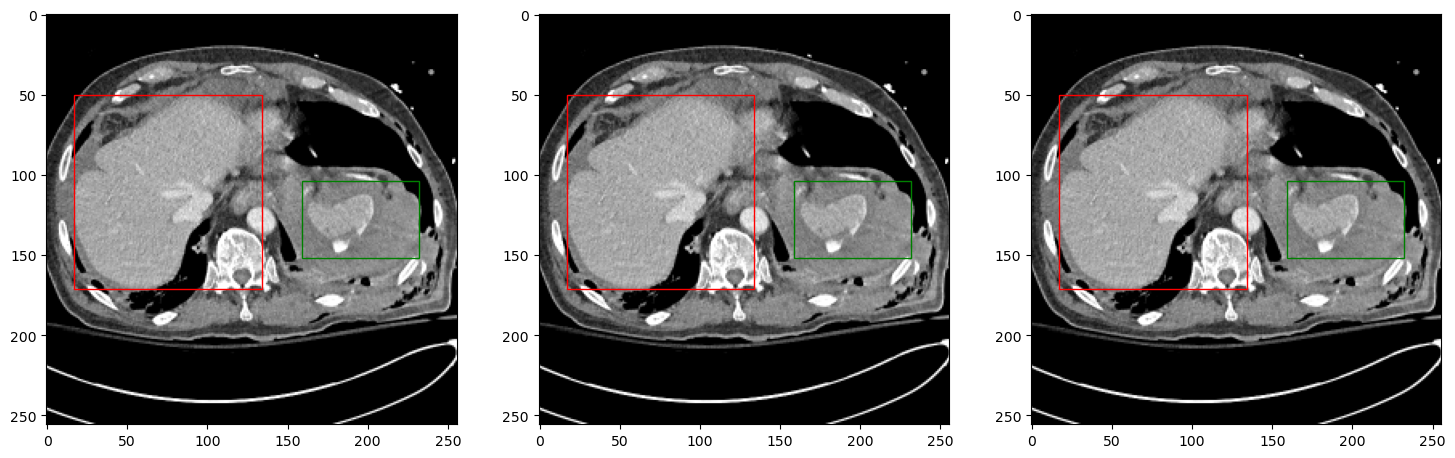

In [20]:
#test if working
sample = train_samples[5]
prepare_sample(sample, train_dirpath, bbox_type = 'pascal_voc') #save

# load
final_image_path = train_dirpath + '/images/' + f"{sample['patient_id']}_{sample['series_id']}_{sample['image_id']}" + '.png'
label_path = train_dirpath + '/labels/' +  f"{sample['patient_id']}_{sample['series_id']}_{sample['image_id']}" + '.txt'

fig, ax = plt.subplots(1,3,figsize=(18,8))

image = cv2.imread(final_image_path, cv2.IMREAD_GRAYSCALE)
ax[0].imshow(image, cmap = 'gray')

with open(label_path) as file:
    for line in file:
        color = color_dict[int(line[0])]
        box = np.fromiter(map(float, line[1:].split()), dtype = float)*256.0
        box = pv2coco(box)
        ax[0].add_patch(patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor=color, facecolor='none', visible=True))
        #ax.add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=color, facecolor='none', visible=True))

sample1 = train_samples[5]
prepare_sample(sample1, train_dirpath, bbox_type = 'yolo') #save

 
final_image_path1 = train_dirpath + '/images/' + f"{sample1['patient_id']}_{sample1['series_id']}_{sample1['image_id']}" + '.png'
label_path1 = train_dirpath + '/labels/' +  f"{sample1['patient_id']}_{sample1['series_id']}_{sample1['image_id']}" + '.txt'
     
image1 = cv2.imread(final_image_path1, cv2.IMREAD_GRAYSCALE)
ax[1].imshow(image1, cmap='gray')

with open(label_path1) as file:
    for line in file:
        color = color_dict[int(line[0])]
        box = np.fromiter(map(float, line[1:].split()), dtype = float)*256.0
        box = yolo2coco(box)
        ax[1].add_patch(patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor=color, facecolor='none', visible=True))

sample2 = train_samples[5]
prepare_sample(sample2, train_dirpath, bbox_type = 'coco') #save
final_image_path2 = train_dirpath + '/images/' + f"{sample2['patient_id']}_{sample2['series_id']}_{sample2['image_id']}" + '.png'

label_path2 = train_dirpath + '/labels/' +  f"{sample2['patient_id']}_{sample2['series_id']}_{sample2['image_id']}" + '.txt'      

image2 = cv2.imread(final_image_path2, cv2.IMREAD_GRAYSCALE)
ax[2].imshow(image2, cmap='gray')

with open(label_path2) as file:
    for line in file:
        color = color_dict[int(line[0])]
        box = np.fromiter(map(float, line[1:].split()), dtype = float)*256.0
        ax[2].add_patch(patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor=color, facecolor='none', visible=True))

        
fig.show()

In [21]:
from joblib import Parallel, delayed
import time

In [22]:
start_time = time.time()
        
Parallel(n_jobs=4)(
    delayed(prepare_sample)(sample, train_dirpath, bbox_type = 'yolo', normalize = True)
    for sample in train_samples
)

Parallel(n_jobs=4)(
    delayed(prepare_sample)(sample, test_dirpath, bbox_type = 'yolo', normalize = True)
    for sample in test_samples
)

print('time taken: ', time.time() - start_time)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


time taken:  237.93877053260803


In [23]:
import yaml
classes = ['liver', 'spleen', 'kidney_left', 'kidney_right']

dataset_dirpath = os.path.join(os.getcwd(), dataset_name)

data ={
        "train": os.path.join("/kaggle/input/rsna-boxes/RSNA_data", "train"),
        "val": os.path.join("/kaggle/input/rsna-boxes/RSNA_data", "val"),
        "names": classes
    }

with open(config_path, mode="w") as f:
    yaml.safe_dump(stream=f, data=data)

In [24]:
train_image_meta.to_pickle(dataset_dirpath+"/train_image_meta.pkl")
val_image_meta.to_pickle(dataset_dirpath+"/val_image_meta.pkl")